
GPT-4o Classification Results:
Filename: Brain Tumor MRI Classification/Testing/no_tumor/image(1).jpg
True Label: no tumor
Predicted Label: no tumor
Score: 4
Analysis: The MRI scan shows an intracerebral hemorrhage on the left side of the brain. There's a noticeable hyperdense region, suggesting acute bleeding. The ventricles appear compressed and shifted towards the opposite side, indicating a mass effect due to the hemorrhage. No distinct tumor mass is visible.

**Final Classification: No tumor**
--------------------------------------------------------------------------------
Filename: Brain Tumor MRI Classification/Testing/no_tumor/image(10).jpg
True Label: no tumor
Predicted Label: no tumor
Score: 5
Analysis: The MRI scan shows a horizontal cross-section of the brain. Observing the brain tissue, there are several features to note:

1. **Gray and White Matter Differentiation**: The differentiation between gray and white matter appears normal and well-defined, without any areas of o

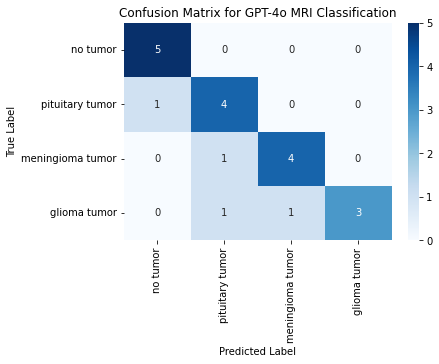

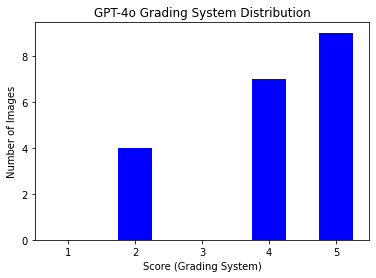

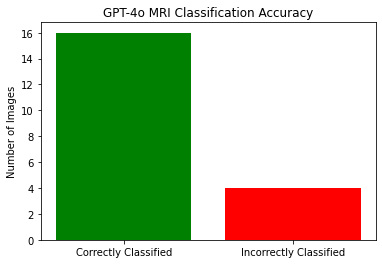

In [26]:
import openai
import base64
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# OpenAI API Key
openai.api_key = "-""
# List of valid tumor classifications
VALID_CONDITIONS = [
    "glioma tumor", "meningioma tumor", "pituitary tumor", "no tumor"
]

# Define dataset paths
BASE_DIR = "Brain Tumor MRI Classification"
TEST_DIR = os.path.join(BASE_DIR, "Testing")

def encode_image(image_path):
    """ Convert an image to base64 encoding for OpenAI Vision API. """
    if not os.path.exists(image_path):
        print(f"Warning: Missing image {image_path}")
        return None
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def analyze_mri(image_path):
    """ Analyzes a brain MRI image with GPT-4o and ensures a detailed analysis before classification. """
    image_base64 = encode_image(image_path)
    if image_base64 is None:
        return None

    try:
        response = openai.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": (
                    "You are an AI specializing in medical image classification for brain MRI scans. "
                    "Analyze the given MRI scan and describe key visual patterns in detail, "
                    "including shape, texture, and any noticeable abnormalities. "
                    "Then, classify the image as one of the following conditions: "
                    + ", ".join(VALID_CONDITIONS) + ". "
                    "**Ensure that you always provide a detailed analysis before stating the classification.** "
                    "At the very end, explicitly state the classification in this format:\n\n"
                    "**Final Classification: [glioma tumor, meningioma tumor, pituitary tumor, or no tumor]**\n\n"
                )},
                {"role": "user", "content": [
                    {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_base64}"}}
                ]}
            ],
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error calling GPT-4o API: {e}")
        return None

def extract_final_classification(analysis_report):
    """ Extracts the final classification label from GPT-4o's response. """
    if not analysis_report:
        return "unknown"

    lines = analysis_report.strip().split("\n")
    for line in reversed(lines):
        line = line.strip().lower()
        if "final classification:" in line:
            pred_label = line.split("final classification:")[-1].strip()
            pred_label = re.sub(r"[^\w\s]", "", pred_label).lower()

            if pred_label in VALID_CONDITIONS:
                return pred_label
            else:
                print(f"Warning: Invalid classification '{pred_label}' from GPT-4o.")
    return "unknown"

def assign_grade(true_label, predicted_label, analysis):
    """ Assigns a score based on classification correctness and justification. """
    true_label = true_label.lower()
    predicted_label = predicted_label.lower()

    if predicted_label == true_label:
        if "texture" in analysis.lower() or "abnormality" in analysis.lower():
            return 5  # Strong justification using key features
        return 4  # Correct classification but missing justification

    elif predicted_label == "unknown":
        return 1  # No useful classification provided

    else:
        return 2  # Incorrect classification but somewhat relevant description

def evaluate_gpt4o(test_folder):
    """ Evaluates GPT-4o performance on the brain tumor MRI dataset. """
    results = []

    # Iterate through each class folder (glioma, meningioma, no tumor, pituitary)
    for class_folder in os.listdir(test_folder):
        class_path = os.path.join(test_folder, class_folder)
        
        if not os.path.isdir(class_path):
            continue  # Skip if it's not a folder

        # Process first 5 images in each class folder
        image_files = sorted(os.listdir(class_path))[:5]

        for img_filename in image_files:
            image_path = os.path.join(class_path, img_filename)
            true_label = class_folder.replace("_", " ")  # Match folder names with VALID_CONDITIONS format
            
            if os.path.exists(image_path):
                analysis_report = analyze_mri(image_path)
                pred_label = extract_final_classification(analysis_report)
                score = assign_grade(true_label, pred_label, analysis_report)
                
                results.append({
                    "image": image_path,
                    "true_label": true_label,
                    "predicted_label": pred_label,
                    "score": score,
                    "analysis": analysis_report
                })
            else:
                print(f"Skipping missing image: {image_path}")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    results_df.to_csv("gpt4o_brain_tumor_results.csv", index=False)
    
    # Display results
    print("\nGPT-4o Classification Results:")
    for _, row in results_df.iterrows():
        print(f"Filename: {row['image']}")
        print(f"True Label: {row['true_label']}")
        print(f"Predicted Label: {row['predicted_label']}")
        print(f"Score: {row['score']}")
        print(f"Analysis: {row['analysis']}")
        print("-" * 80)
    
    # Convert all labels to lowercase for consistency
    y_true = results_df['true_label'].str.lower()
    y_pred = results_df['predicted_label'].str.lower()

    # Generate a unique set of labels
    unique_labels = list(set(y_true.unique()) | set(y_pred.unique()))
    unique_labels = [label for label in unique_labels if label != "unknown"]  

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=unique_labels, zero_division=1))

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for GPT-4o MRI Classification")
    plt.show()

    # Bar Graph: Grading System (Ensure All Scores 1-5 are Displayed)
    score_counts = results_df['score'].value_counts().reindex([1, 2, 3, 4, 5], fill_value=0)
    plt.figure(figsize=(6, 4))
    score_counts.plot(kind='bar', color='blue')
    plt.xlabel("Score (Grading System)")
    plt.ylabel("Number of Images")
    plt.title("GPT-4o Grading System Distribution")
    plt.xticks(rotation=0)
    plt.show()

    # Bar Graph: Correct vs Incorrect Classifications
    correct_classifications = (y_true == y_pred).sum()
    incorrect_classifications = len(y_true) - correct_classifications

    plt.figure(figsize=(6, 4))
    plt.bar(["Correctly Classified", "Incorrectly Classified"], [correct_classifications, incorrect_classifications], color=['green', 'red'])
    plt.ylabel('Number of Images')
    plt.title('GPT-4o MRI Classification Accuracy')
    plt.xticks(rotation=0)
    plt.show()

# Run evaluation on the Testing dataset
if os.path.exists(TEST_DIR):
    evaluate_gpt4o(TEST_DIR)
else:
    print("Testing dataset folder not found! Ensure you provide a valid path.")
